In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import math
#import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
%matplotlib inline

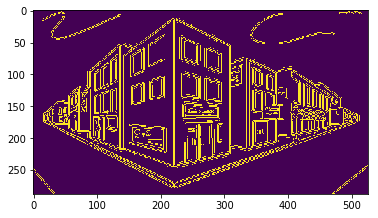

In [2]:
# image = cv2.imread('/Users/scoot/Documents/GitHub/VB-Research/Scott-Notes/Sample5-1_Moment.jpg',1)
image = cv2.imread('/home/scott/VB-Research/Scott-Notes/perspective5.png',1)

gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray,10,10,apertureSize=3)
plt.imshow(edges)

In [3]:
lines = cv2.HoughLines(edges,1,np.pi/180,140)
# print(lines[0])

In [4]:
equations = []
for i in range(len(lines)):
    for rho,theta in lines[i]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        x = [x1,x2]
        y = [y1,y2]
        print("x:", x)
        print("y:", y)
        temp = x2-x1
        if (temp) == 0:
            temp = 0.0001
        slope = float((y2-y1))/float((temp))
        print("slope: ", slope)
        intercept = y1 - (slope*x1)
        print("intercept:", intercept)
        equations.append((slope,intercept))
#         coeff = np.polyfit(x,y,1)
#         poly = np.poly1d(coeff)
        cv2.line(image,(x1,y1),(x2,y2),(0,0,255),2)
cv2.imwrite('detectedLines.jpg',image)
print("num of lines:", len(equations))

x: [220, 220]
y: [1000, -1000]
slope:  -20000000.0
intercept: 4400001000.0
x: [-824, 1055]
y: [659, -24]
slope:  -0.3634912187333688
intercept: 359.4832357637041
x: [222, 222]
y: [1000, -1000]
slope:  -20000000.0
intercept: 4440001000.0
x: [-824, 1054]
y: [657, -26]
slope:  -0.36368477103301383
intercept: 357.3237486687966
x: [-969, 842]
y: [-286, 558]
slope:  0.46604086140254003
intercept: 165.59359469906127
x: [308, 308]
y: [1000, -1000]
slope:  -20000000.0
intercept: 6160001000.0
x: [135, 135]
y: [1000, -1000]
slope:  -20000000.0
intercept: 2700001000.0
x: [137, 137]
y: [1000, -1000]
slope:  -20000000.0
intercept: 2740001000.0
x: [310, 310]
y: [1000, -1000]
slope:  -20000000.0
intercept: 6200001000.0
x: [-1002, 997]
y: [145, 180]
slope:  0.017508754377188594
intercept: 162.54377188594296
x: [-1004, 993]
y: [121, 190]
slope:  0.03455182774161242
intercept: 155.69003505257888
x: [-996, 1002]
y: [195, 160]
slope:  -0.017517517517517518
intercept: 177.55255255255256
x: [-900, 1040]
y: [

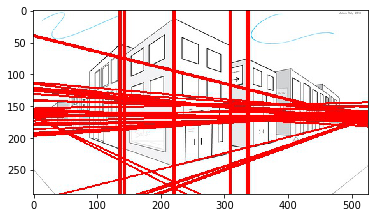

In [5]:
im2 = cv2.imread('detectedLines.jpg',1)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
plt.imshow(im2)

In [6]:
intersectionPoints = []
for i in range(len(equations)):
    for j in range(i+1,len(equations)):
        e1slope = equations[i][0]
        e1inter = equations[i][1]
        e2slope = equations[j][0]
        e2inter = equations[j][1]
        if((e2slope - e1slope) == 0):
            break
        xint = (e1inter - e2inter) / (e2slope - e1slope)
        yint = (e1slope * xint) + e1inter
#         print("x:",xint)
#         print("y:",yint)
        intersectionPoints.append([xint,yint])

In [7]:
# print(len(intersectionPoints))
# print(len(equations))
dfIP = pd.DataFrame(intersectionPoints,columns=['x','y'])
# print(dfIP)

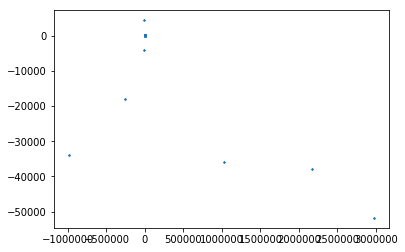

In [8]:
# dfIP = dfIP.loc[dfIP['x'] <10000]
# meanx = dfIP['x'].median()
# sdx = dfIP['x'].quantile(0.75) - dfIP['x'].quantile(0.25) 
# meany = dfIP['y'].median()
# sdy = dfIP['y'].quantile(0.75) - dfIP['y'].quantile(0.25)

# print("before:",len(dfIP))
# dfIP = dfIP[dfIP.x <= (meanx + 1.5*sdx)]
# dfIP = dfIP[dfIP.x >= (meanx - 1.5*sdx)]

# dfIP = dfIP[dfIP.y <= (meany + 1.5*sdy)]
# dfIP = dfIP[dfIP.y >= (meany - 1.5*sdy)]
# print("after:",len(dfIP))

# print(meanx,meany,sdx,sdy)
# dfIP = dfIP[dfIP.x <= 10000]
# print(dfIP)
plt.scatter(dfIP.x,dfIP.y,marker='*',s=3)
plt.show()

In [9]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(dfIP)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
labels = kmeans.predict(dfIP)
centroids = kmeans.cluster_centers_

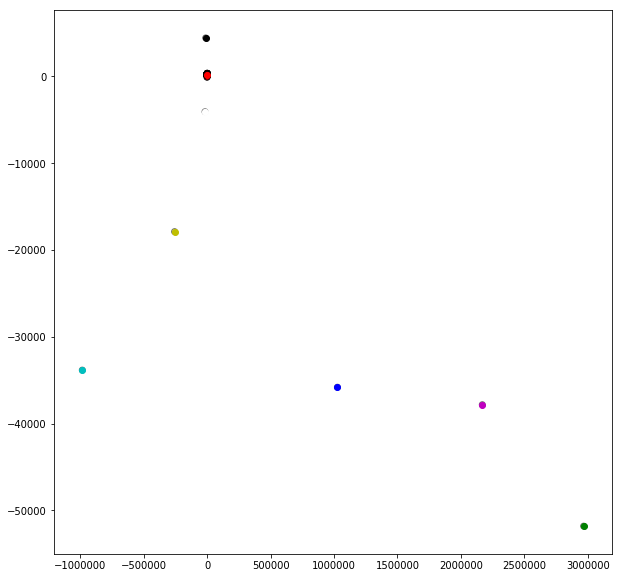

In [11]:
fig = plt.figure(figsize=(10, 10))
colmap = {1: 'r', 2: 'g', 3: 'b', 4:'c', 5: 'm', 6: 'y', 7: 'k', 8: 'w'}
colors = list(map(lambda x: colmap[x+1], labels))

plt.scatter(dfIP['x'], dfIP['y'], color=colors, alpha=0.5, edgecolor='k')
for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, color=colmap[idx+1])
# plt.xlim(0, 80)
# plt.ylim(0, 80)
plt.show()

In [12]:
print(centroids)

[[  3.72767361e+02   1.71752893e+02]
 [  2.96797491e+06  -5.18120000e+04]
 [  1.02700654e+06  -3.58130000e+04]
 [ -9.84048957e+05  -3.38430000e+04]
 [  2.16917451e+06  -3.78260000e+04]
 [ -2.56736500e+05  -1.78950000e+04]
 [ -1.11571245e+04   4.41500000e+03]
 [ -1.65552319e+04  -4.08300000e+03]]


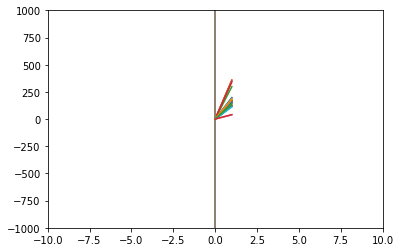

In [17]:
plt.figure()
plt.xlim(-10,10)
plt.ylim(-1000,1000)
for eqn in equations:
    plt.plot(eqn)
plt.show()